# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# 1.Clean The Data

In [74]:
import math
import json
import re
import os
import matplotlib
import pandas as pd
from time import time
import numpy as np
import seaborn as sns
from pprint import pprint
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer,MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier ,RandomForestClassifier
from datetime import datetime
from sklearn.base import clone
from sklearn.metrics import make_scorer ,fbeta_score, accuracy_score ,f1_score, accuracy_score
from sklearn.model_selection import train_test_split ,GridSearchCV
import matplotlib.patches as mpatches

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1.1 portfolio Data
- Changed the name of the 'id' column to 'offerid'
- Removed underscores from column names
- One hot encode the 'offertype' column and 'channels' columns


In [75]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [76]:
def update_column_name(dataframe,
                       old_column_name,
                       new_column_name):
    """ Updates a Pandas DataFrame column name
    INPUT:
        dataframe: Pandas DataFrame object
        old_column_name: String that stores the old column name
        new_column_name: String that stores the new column name
    OUTPUT:
        column_names: np.array that stores the updated Pandas DataFrame
                      column names"""
    column_names = dataframe.columns.values
    
    select_data = np.array([elem == old_column_name for elem in column_names])

    column_names[select_data] = new_column_name
        
    return column_names
def convert_to_datetime(elem):
    """Converts a string to a datetime object
    
    INPUT:
        elem: String that stores a date in the %Y%m%d format
    OUTPUT:
        datetimeobj: Datetime object"""
    return datetime.strptime(str(elem), '%Y%m%d')

In [77]:
def clean_portfolio(data_dir="./data"):
    """ 
    Transforms a DataFrame containing offer ids and meta data about 
    each offer (duration, type, etc.)
    INPUT:
        (Optional) data_dir: String that stores the full path to the
                             data directory
    OUTPUT:
        portfolio: DataFrame containing offer ids and meta data about 
                   each offer (duration, type, etc.)
    """
    portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
    
    # Change the name of the 'id' column to 'offerid'
    columns = update_column_name(portfolio,'id','offerid')
    


    # Remove underscores from column names
    portfolio.columns = [re.sub('_', '', elem) for elem in columns]

    # Initialize a list that stores the desired output DataFrame 
    # column ordering
    

    # Return the "cleaned" portfolio data
    return portfolio
portfolio = clean_portfolio()
portfolio

,reward,channels,difficulty,duration,offertype,offerid
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [78]:
column_ordering = ['offerid',
                   'difficulty',
                   'durationdays',
                   'reward']

    # One hot encode the 'offertype' column
offertype_df = pd.get_dummies(portfolio['offertype'])

column_ordering.extend(offertype_df.columns.values)

    # One hot encode the 'channels' columns
ml_binarizerobj = MultiLabelBinarizer()
ml_binarizerobj.fit(portfolio['channels'])

channels_df =\
    pd.DataFrame(ml_binarizerobj.transform(portfolio['channels']),
    columns=ml_binarizerobj.classes_)

column_ordering.extend(channels_df.columns.values)

    # Replace the 'offertype' and 'channels' columns
portfolio = pd.concat([portfolio, offertype_df, channels_df], axis=1)

portfolio = portfolio.drop(columns=['offertype', 'channels'])

In [79]:
portfolio.head()

,reward,difficulty,duration,offerid,bogo,discount,informational,email,mobile,social,web
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1


#  profile
- Removed customers with missing income data and customer profiles where the gender attribute is missing
- Changed the name of the 'id' column to 'customerid'
- Transformed the 'became_member_on' column to a datetime object and gender column from a character to a number.
- One hot encode a customer's membership start year, start Month and age range


In [80]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [81]:
def clean_profile(data_dir = "./data"):
    """ Transforms a DataFrame that contains demographic data for each 
    customer
    
    INPUT:
        (Optional) data_dir: String that stores the full path to the
                             data directory
    
    OUTPUT:
        profile: DataFrame that contains demographic data for each 
                 customer
    """
    profile = pd.read_json('data/profile.json',
                           orient='records',
                           lines=True)
    profile_remove = profile[profile.age == 118]

    # Remove customers with N/A income data
    profile = profile[profile['income'].notnull()]

    # Remove customers with unspecified gender
    profile = profile[profile['gender'] != 'O']
    profile = profile.reset_index(drop=True)

    # Change the name of the 'id' column to 'customerid'
    profile.columns = update_column_name(profile,
                                         'id',
                                         'customerid')

    # Initialize a list that describes the desired DataFrame column
    # ordering
    column_ordering = ['customerid',
                       'gender',
                       'income']

    # Transform the 'became_member_on' column to a datetime object
    profile['became_member_on']= profile['became_member_on'].apply(convert_to_datetime)

    # One hot encode a customer's membership start year
    profile['membershipstartyear'] =\
        profile['became_member_on'].apply(lambda elem: elem.year)
    
    # One hot encode a customer's membership start month
    profile['membershipstartMonth'] =\
        profile['became_member_on'].apply(lambda elem: elem.month)

     

    # Transform a customer's gender from a character to a number
    recode = {'M': 0, 'F': 1}
    profile.replace({'gender': recode}, inplace=True)
    
    min_age_limit = np.int(np.floor(np.min(profile['age'])/10)*10)
    max_age_limit = np.int(np.ceil(np.max(profile['age'])/10)*10)

    profile['agerange'] =\
        pd.cut(profile['age'],
               (range(min_age_limit,max_age_limit + 10, 10)),
               right=False)
    profile['agerange'] = profile['agerange'].astype('str')

    # Return a DataFrame with "clean" customer profile data
    return profile

In [82]:
profile = clean_profile()

In [83]:
profile.head()

,gender,age,customerid,became_member_on,income,membershipstartyear,membershipstartMonth,agerange
0,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,"[50, 60)"
1,1,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,"[70, 80)"
2,0,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4,"[60, 70)"
3,0,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2,"[60, 70)"
4,0,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11,"[50, 60)"


In [84]:
column_ordering = []
agerange_df = pd.get_dummies(profile['agerange'])
column_ordering.extend(agerange_df.columns.values)
profile = pd.concat([profile,agerange_df], axis=1)
profile.head()

,gender,age,customerid,became_member_on,income,membershipstartyear,membershipstartMonth,agerange,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,"[50, 60)",0,0,0,0,0,1,0,0,0,0
1,1,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,"[70, 80)",0,0,0,0,0,0,0,1,0,0
2,0,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4,"[60, 70)",0,0,0,0,0,0,1,0,0,0
3,0,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2,"[60, 70)",0,0,0,0,0,0,1,0,0,0
4,0,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11,"[50, 60)",0,0,0,0,0,1,0,0,0,0


#  Transcript Data

- I changed the name of the 'person' column to 'customerid'and 'time' column to 'timedays',removed customer id's that are not in the customer profile DataFrame. also,converted time variable from hours to days
- Create a two DataFrame that describes: offers and customer transaction events.
- One hot encode offer events



In [85]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [86]:
def clean_transcript(profile,
                     data_dir = './data'):
    """ Transforms a DataFrame that contains records for transactions, offers
    received, offers viewed, and offers completed
    INPUT:
        profile: DataFrame that contains demographic data for each 
                 customer
        (Optional) data_dir: String that stores the full path to the
                             data directory
    OUTPUT:
        offer_data: DataFrame that describes customer offer data
        transaction: DataFrame that describes customer transactions
    """
    transcript = pd.read_json(os.path.join(data_dir,
                                           'transcript.json'),
                              orient='records',
                              lines=True)

    # Change the name of the 'person' column to 'customerid'
    transcript.columns = update_column_name(transcript,
                                            'person',
                                            'customerid')

    # Remove customer id's that are not in the customer profile DataFrame
    select_data = transcript['customerid'].isin(profile['customerid'])
    transcript = transcript[select_data]

    percent_removed = 100 * (1 - select_data.sum() / select_data.shape[0])
    print("Percentage of transactions removed: %.2f %%" % percent_removed)

    # Convert from hours to days
    transcript['time'] /= 24.0
    
    # Change the name of the 'time' column to 'timedays'
    transcript.columns = update_column_name(transcript,
                                            'time',
                                            'timedays')

    # Select customer offers
    pattern_obj = re.compile('^offer (?:received|viewed|completed)')

    h_is_offer = lambda elem: pattern_obj.match(elem) != None

    is_offer = transcript['event'].apply(h_is_offer)

    offer_data = transcript[is_offer].copy()
    offer_data = offer_data.reset_index(drop=True)

    # Initialize a list that describes the desired output DataFrame
    # column ordering
    column_order = ['offerid', 'customerid', 'timedays']

    # Create an offerid column
    offer_data['offerid'] =\
        offer_data['value'].apply(lambda elem: list(elem.values())[0])

    # Transform a column that describes a customer offer event
    pattern_obj = re.compile('^offer ([a-z]+$)')

    h_transform = lambda elem: pattern_obj.match(elem).groups(1)[0]

    offer_data['event'] = offer_data['event'].apply(h_transform)

    # One hot encode customer offer events
    event_df = pd.get_dummies(offer_data['event'])
    column_order.extend(event_df.columns.values)

    # Create a DataFrame that describes customer offer events
    offer_data = pd.concat([offer_data, event_df], axis=1)
    offer_data.drop(columns=['event', 'value'])
    offer_data = offer_data[column_order]

    # Select customer transaction events
    transaction = transcript[is_offer == False]
    transaction = transaction.reset_index(drop=True)

    # Transform customer transaction event values
    transaction['amount'] =\
        transaction['value'].apply(lambda elem: list(elem.values())[0])

    # Create a DataFrame that describes customer transactions
    transaction = transaction.drop(columns=['event','timedays'])
    column_order = ['customerid', 'amount']
    transaction = transaction[column_order]

    return offer_data, transaction

In [87]:
transcript.shape

(306534, 4)

In [88]:
offer_data, transaction = clean_transcript(profile)
#transaction = pd.merge(transaction, offer_data, on='customerid')
transaction.head()

Percentage of transactions removed: 12.31 %


,customerid,amount
0,02c083884c7d45b39cc68e1314fec56c,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,34.56
2,54890f68699049c2a04d415abc25e717,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,18.97


In [89]:
offer_data.head()

,offerid,customerid,timedays,completed,received,viewed
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,0,1,0
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0,1,0
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0.0,0,1,0
3,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0.0,0,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0.0,0,1,0


#  Explore the Data

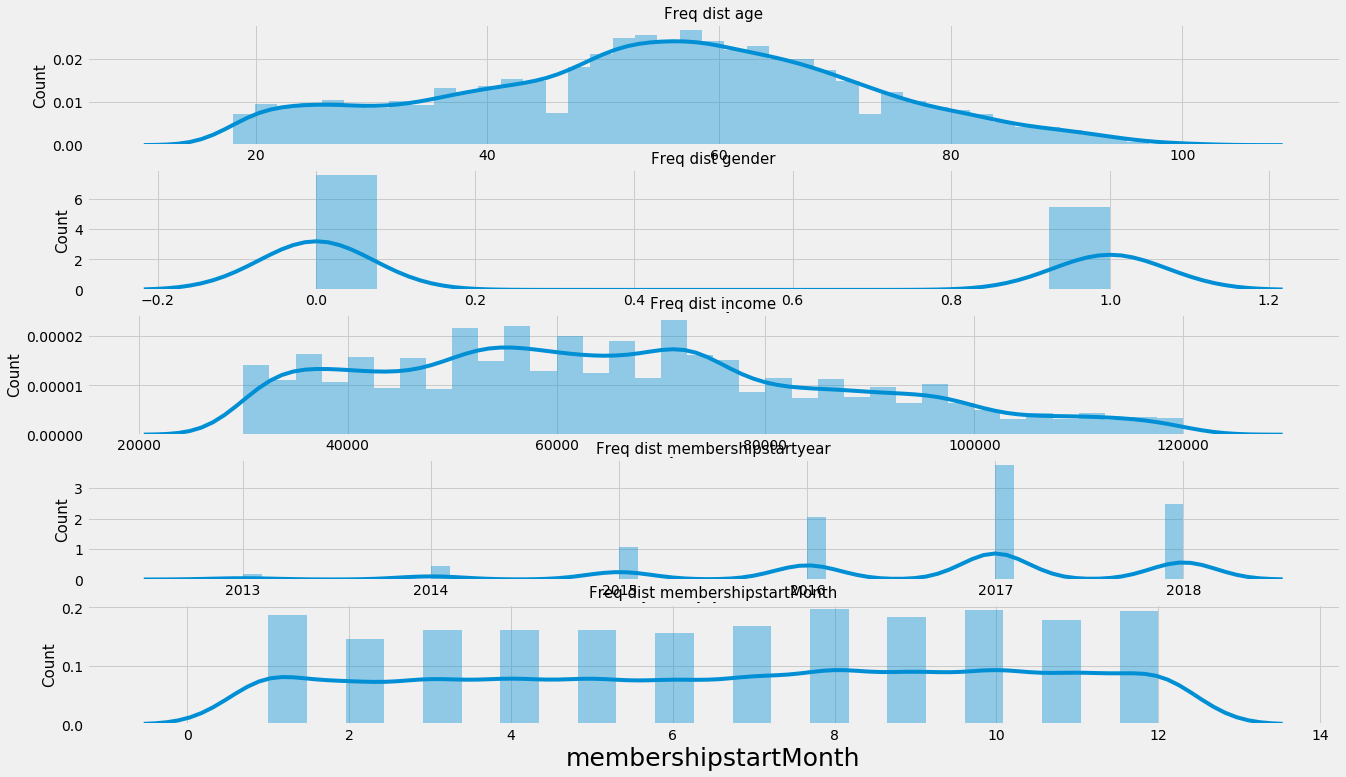

In [90]:
col_names = ['age', 'gender', 'income', 'membershipstartyear','membershipstartMonth']

fig, ax = plt.subplots(len(col_names), figsize=(20,12))

for i, col_val in enumerate(col_names):
    sns.distplot(profile[col_val], hist=True, ax=ax[i]) 
    ax[i].set_title("Freq dist " + col_val, fontsize=15)
    ax[i].set_xlabel(col_val, fontsize=25)
    ax[i].set_ylabel('Count', fontsize=15)
plt.show()

## Income by gender for each Month

In [91]:
profileforFemale = profile.copy()
profileforFemale = profileforFemale[profileforFemale['gender'] == 1]
profileforFemale.head()


,gender,age,customerid,became_member_on,income,membershipstartyear,membershipstartMonth,agerange,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,"[50, 60)",0,0,0,0,0,1,0,0,0,0
1,1,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,"[70, 80)",0,0,0,0,0,0,0,1,0,0
5,1,61,aa4862eba776480b8bb9c68455b8c2e1,2017-09-11,57000.0,2017,9,"[60, 70)",0,0,0,0,0,0,1,0,0,0
7,1,62,31dda685af34476cad5bc968bdb01c53,2016-02-11,71000.0,2016,2,"[60, 70)",0,0,0,0,0,0,1,0,0,0
10,1,61,a448667f336b42c9a66fc5ffd5d73772,2018-05-01,40000.0,2018,5,"[60, 70)",0,0,0,0,0,0,1,0,0,0


In [92]:
datamembershipstartMonthF = profileforFemale.groupby('membershipstartMonth')['income'].sum().reset_index()
datamembershipstartMonthF.reset_index(drop=True)
datamembershipstartMonthF.head()

,membershipstartMonth,income
0,1,36809000.0
1,2,27369000.0
2,3,34506000.0
3,4,32908000.0
4,5,32377000.0
5,6,31747000.0
6,7,36168000.0
7,8,41128000.0
8,9,38705000.0
9,10,41857000.0


In [93]:
profileforMale = profile.copy()
profileforMale = profileforMale[profileforMale['gender'] == 0]
profileforMale.head()

,gender,age,customerid,became_member_on,income,membershipstartyear,membershipstartMonth,agerange,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
2,0,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4,"[60, 70)",0,0,0,0,0,0,1,0,0,0
3,0,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2,"[60, 70)",0,0,0,0,0,0,1,0,0,0
4,0,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11,"[50, 60)",0,0,0,0,0,1,0,0,0,0
6,0,26,e12aeaf2d47d42479ea1c4ac3d8286c6,2014-02-13,46000.0,2014,2,"[20, 30)",0,0,1,0,0,0,0,0,0,0
8,0,49,62cf5e10845442329191fc246e7bcea3,2014-11-13,52000.0,2014,11,"[40, 50)",0,0,0,0,1,0,0,0,0,0


In [94]:
datamembershipstartMonthM = profileforMale.groupby('membershipstartMonth')['income'].sum().reset_index()
datamembershipstartMonthM.reset_index(drop=True)
datamembershipstartMonthM.head()

,membershipstartMonth,income
0,1,47689000.0
1,2,38517000.0
2,3,38677000.0
3,4,40552000.0
4,5,42459000.0
5,6,40005000.0
6,7,40591000.0
7,8,50304000.0
8,9,45555000.0
9,10,47512000.0


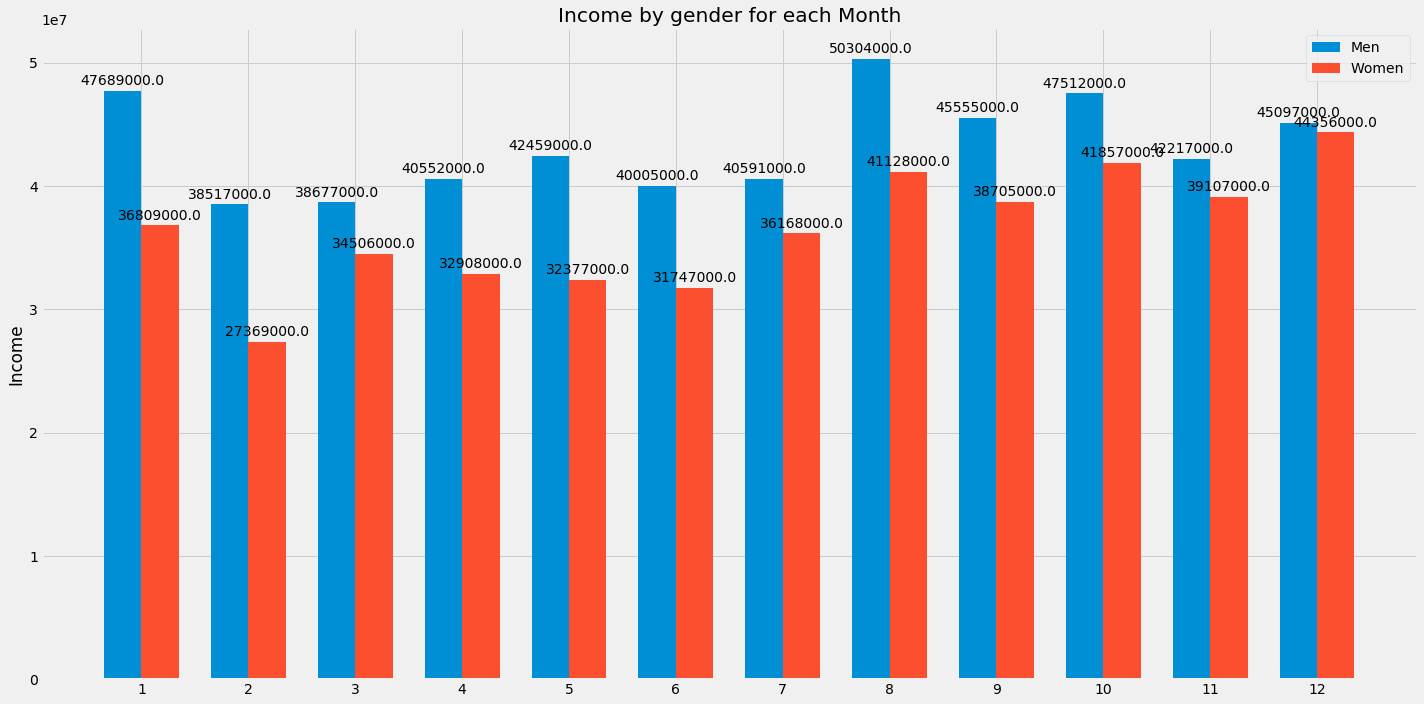

In [95]:
plt.style.use('fivethirtyeight')
labels = datamembershipstartMonthM.membershipstartMonth
men = datamembershipstartMonthM.income
women = datamembershipstartMonthF.income

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width/2, men, width, label='Men')
rects2 = ax.bar(x + width/2, women, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Income')
ax.set_title('Income by gender for each Month')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### Income by gender for each Year

In [96]:
datamembershipstartyearF = profileforFemale.groupby('membershipstartyear')['income'].sum().reset_index()
datamembershipstartyearF.reset_index(drop=True)
datamembershipstartyearF.head(12)

,membershipstartyear,income
0,2013,4567000.0
1,2014,8468000.0
2,2015,47701000.0
3,2016,112994000.0
4,2017,174463000.0
5,2018,88844000.0


In [97]:
datamembershipstartyearM = profileforMale.groupby('membershipstartyear')['income'].sum().reset_index()
datamembershipstartyearM.reset_index(drop=True)
datamembershipstartyearM.head(12)

,membershipstartyear,income
0,2013,11030000.0
1,2014,29828000.0
2,2015,57476000.0
3,2016,98242000.0
4,2017,187731000.0
5,2018,134868000.0


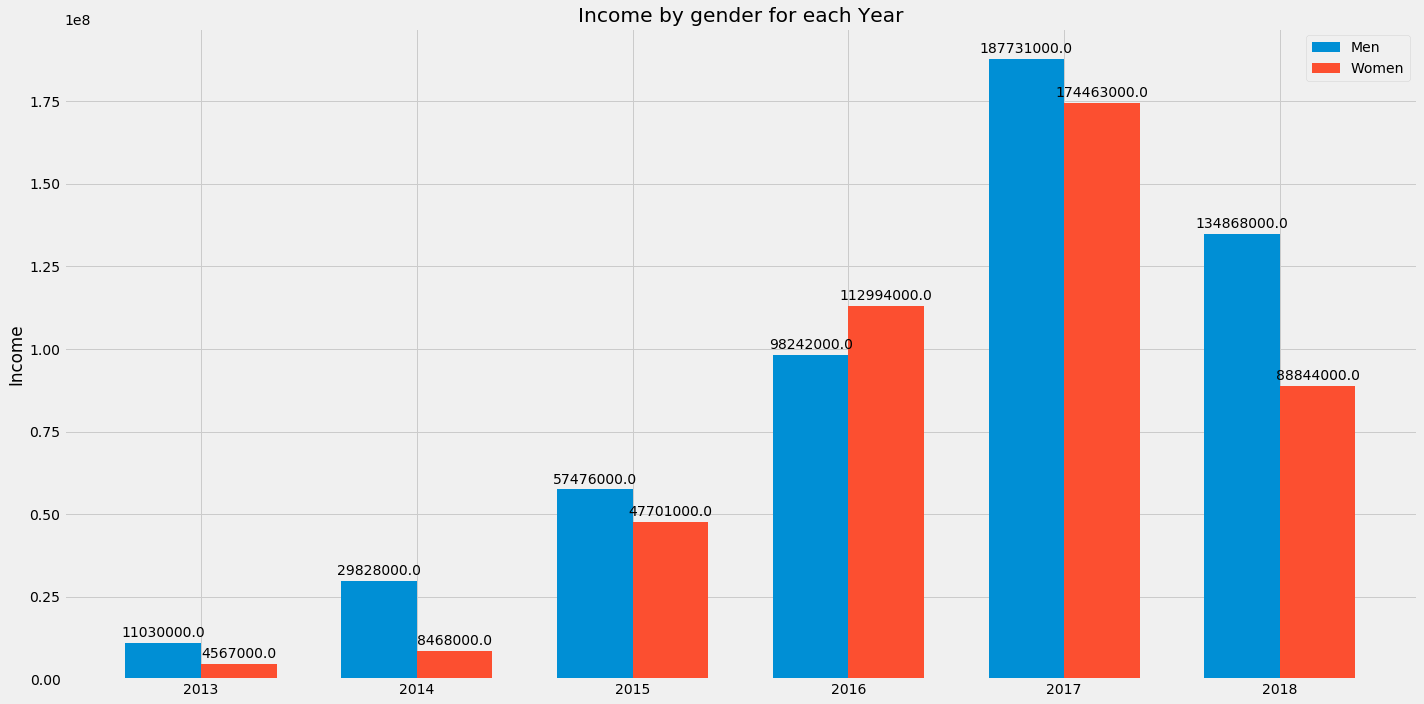

In [98]:
plt.style.use('fivethirtyeight')
labels = datamembershipstartyearM.membershipstartyear
men = datamembershipstartyearM.income
women = datamembershipstartyearF.income

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width/2, men, width, label='Men')
rects2 = ax.bar(x + width/2, women, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Income')
ax.set_title('Income by gender for each Year')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [99]:
### Count and Sum Income by Gender 

In [100]:
dataGender = profile.groupby('gender')['income'].sum().reset_index()
dataGender.reset_index(drop=True)
dataGender.head()

,gender,income
0,0,519175000.0
1,1,437037000.0


In [101]:
dataGenderCount = profile.groupby('gender')['income'].count().reset_index()
dataGenderCount.reset_index(drop=True)
dataGenderCount.head()

,gender,income
0,0,8484
1,1,6129


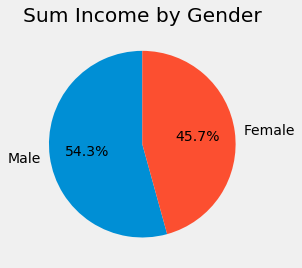

In [102]:

plt.style.use('fivethirtyeight')
slices_hours = dataGender.income
activities = ['Male', 'Female']
plt.pie( slices_hours, startangle=90, labels=activities, autopct='%.1f%%')
plt.title('Sum Income by Gender')
plt.show()

### Timeline for Sum of income by Year

In [103]:
# One hot encode a customer's age range
min_age_limit = np.int(np.floor(np.min(profile['age'])/10)*10)
max_age_limit = np.int(np.ceil(np.max(profile['age'])/10)*10)

# Make age range 
profile['agerange'] =\
    pd.cut(profile['age'],
            (range(min_age_limit,max_age_limit + 10, 10)),
            right=False)
profile['agerange'] = profile['agerange'].astype('str') 

In [104]:
profile.agerange.value_counts()

[50, 60)      3485
[60, 70)      2952
[40, 50)      2269
[70, 80)      1757
[30, 40)      1503
[20, 30)      1353
[80, 90)       821
[90, 100)      252
[10, 20)       205
[100, 110)      16
Name: agerange, dtype: int64

In [105]:
data_became_member_on = profile.sort_values('became_member_on')
income = data_became_member_on.groupby('became_member_on')['income'].sum().reset_index()
income = income.set_index('became_member_on')
y_income = income['income'].resample('BMS').sum()
income = pd.DataFrame({'became_member_on':y_income.index, 'income':y_income.values})
#store.rename(columns={'Sum_x': 'income', 'Sum_y': 'revenue'}, inplace=True)
income.head()

,became_member_on,income
0,2013-07-01,321000.0
1,2013-08-01,3889000.0
2,2013-09-02,3104000.0
3,2013-10-01,3000000.0
4,2013-11-01,2513000.0


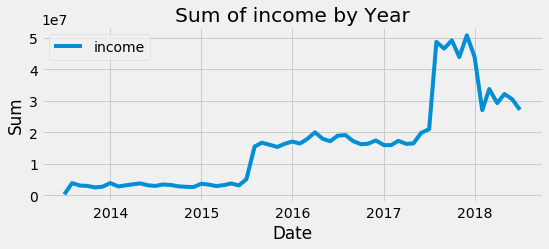

In [106]:
plt.figure(figsize=(8, 3))
plt.plot(income['became_member_on'], income['income'], label = 'income')
#plt.plot(profile['became_member_on'], profile['revenue'], label = 'revenue')
plt.xlabel('Date'); plt.ylabel('Sum'); plt.title('Sum of income by Year')
plt.legend();



### Income for Age Range

In [107]:
min_age_limit = np.int(np.floor(np.min(profile['age'])/10)*10)
max_age_limit = np.int(np.ceil(np.max(profile['age'])/10)*10)

profile['agerange'] =\
    pd.cut(profile['age'],
            (range(min_age_limit,max_age_limit + 10, 10)),
            right=False)
profile['agerange'] = profile['agerange'].astype('str')
profile.head()

,gender,age,customerid,became_member_on,income,membershipstartyear,membershipstartMonth,agerange,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,"[50, 60)",0,0,0,0,0,1,0,0,0,0
1,1,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,"[70, 80)",0,0,0,0,0,0,0,1,0,0
2,0,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4,"[60, 70)",0,0,0,0,0,0,1,0,0,0
3,0,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2,"[60, 70)",0,0,0,0,0,0,1,0,0,0
4,0,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11,"[50, 60)",0,0,0,0,0,1,0,0,0,0


In [108]:
dataAgeRange = profile.groupby('agerange')['income'].sum().reset_index()
dataAgeRange.head()

,agerange,income
0,"[10, 20)",10350000.0
1,"[100, 110)",1187000.0
2,"[20, 30)",69191000.0
3,"[30, 40)",80634000.0
4,"[40, 50)",139711000.0


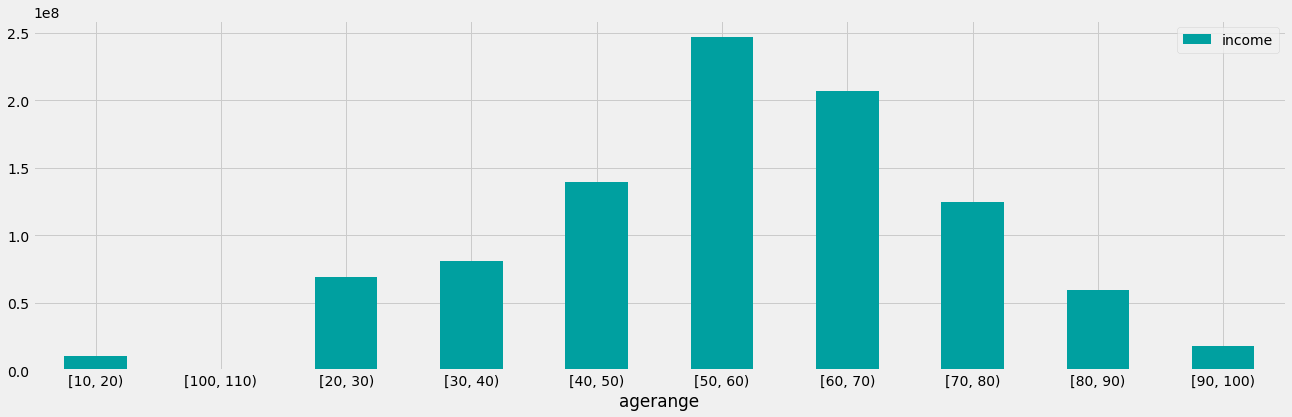

In [109]:
ax = dataAgeRange.plot.bar(x='agerange', y='income', rot=0, figsize=(20,6),color = '#00A0A0')

# 3. Preparing the Data

In [110]:
alldata1 = pd.merge(profile, transaction, on='customerid')
alldata2 = pd.merge(alldata1, offer_data, on='customerid')
alldata3 = pd.merge(alldata2, portfolio, on='offerid')
alldata3.head()

,gender,age,customerid,became_member_on,income,membershipstartyear,membershipstartMonth,agerange,"[10, 20)","[100, 110)",...,reward,difficulty,duration,bogo,discount,informational,email,mobile,social,web
0,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,"[50, 60)",0,0,...,5,5,7,1,0,0,1,1,0,1
1,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,"[50, 60)",0,0,...,5,5,7,1,0,0,1,1,0,1
2,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,"[50, 60)",0,0,...,5,5,7,1,0,0,1,1,0,1
3,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,"[50, 60)",0,0,...,5,5,7,1,0,0,1,1,0,1
4,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,"[50, 60)",0,0,...,5,5,7,1,0,0,1,1,0,1


In [111]:
mean = alldata3.income.mean()
print(mean)

62718.77456631501


In [112]:
alldata3['income'] = alldata3.income.map(lambda x: 0 if x <= 62718.77  else 1)

In [113]:
n_records = len(alldata3)
n_greater_mean = len(alldata3[alldata3.income == 1])
n_at_most = len(alldata3[alldata3.income == 0])

In [114]:
print(n_records)
print(n_greater_mean)
print(n_at_most)

1308957
608367
700590


# 4.Modelling

In [115]:
alldata3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1308957 entries, 0 to 1308956
Data columns (total 34 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   gender                1308957 non-null  int64         
 1   age                   1308957 non-null  int64         
 2   customerid            1308957 non-null  object        
 3   became_member_on      1308957 non-null  datetime64[ns]
 4   income                1308957 non-null  int64         
 5   membershipstartyear   1308957 non-null  int64         
 6   membershipstartMonth  1308957 non-null  int64         
 7   agerange              1308957 non-null  object        
 8   [10, 20)              1308957 non-null  uint8         
 9   [100, 110)            1308957 non-null  uint8         
 10  [20, 30)              1308957 non-null  uint8         
 11  [30, 40)              1308957 non-null  uint8         
 12  [40, 50)              1308957 non-null  ui

In [116]:
alldata3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1308957 entries, 0 to 1308956
Data columns (total 34 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   gender                1308957 non-null  int64         
 1   age                   1308957 non-null  int64         
 2   customerid            1308957 non-null  object        
 3   became_member_on      1308957 non-null  datetime64[ns]
 4   income                1308957 non-null  int64         
 5   membershipstartyear   1308957 non-null  int64         
 6   membershipstartMonth  1308957 non-null  int64         
 7   agerange              1308957 non-null  object        
 8   [10, 20)              1308957 non-null  uint8         
 9   [100, 110)            1308957 non-null  uint8         
 10  [20, 30)              1308957 non-null  uint8         
 11  [30, 40)              1308957 non-null  uint8         
 12  [40, 50)              1308957 non-null  ui

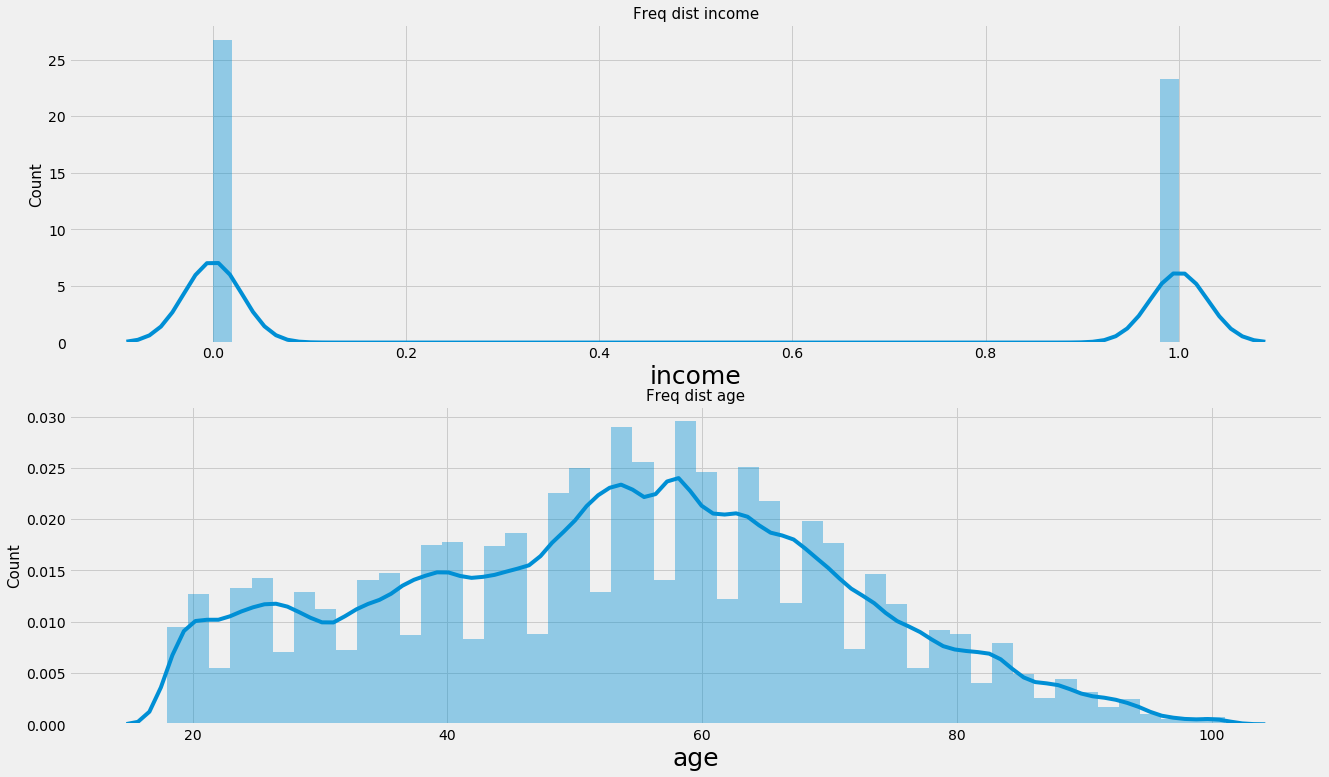

In [117]:
col_names = ['income', 'age']

fig, ax = plt.subplots(len(col_names), figsize=(20,12))

for i, col_val in enumerate(col_names):
    sns.distplot(alldata3[col_val], hist=True, ax=ax[i]) 
    ax[i].set_title("Freq dist " + col_val, fontsize=15)
    ax[i].set_xlabel(col_val, fontsize=25)
    ax[i].set_ylabel('Count', fontsize=15)
plt.show()

## 1.Transforming Skewed Continuous Features

In [118]:
income_raw = alldata3['income']
features_raw = alldata3.drop(['income'], axis = 1)

In [119]:
features_raw = features_raw.drop(['became_member_on','customerid','agerange', 'offerid',
                          '[10, 20)','[100, 110)',
                          '[20, 30)','[30, 40)',
                          '[40, 50)','[50, 60)',
                          '[60, 70)','[70, 80)',
                          '[80, 90)','[90, 100)'], axis = 1)

In [120]:
features_raw.head()

,gender,age,membershipstartyear,membershipstartMonth,amount,timedays,completed,received,viewed,reward,difficulty,duration,bogo,discount,informational,email,mobile,social,web
0,1,55,2017,7,21.51,17.0,0,1,0,5,5,7,1,0,0,1,1,0,1
1,1,55,2017,7,21.51,22.0,1,0,0,5,5,7,1,0,0,1,1,0,1
2,1,55,2017,7,32.28,17.0,0,1,0,5,5,7,1,0,0,1,1,0,1
3,1,55,2017,7,32.28,22.0,1,0,0,5,5,7,1,0,0,1,1,0,1
4,1,55,2017,7,23.22,17.0,0,1,0,5,5,7,1,0,0,1,1,0,1


In [121]:
skewed = ['membershipstartyear', 'membershipstartMonth']
features_raw[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

## 2.Normalizing Numerical Features

In [122]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'membershipstartyear',
             'membershipstartMonth','amount',
             'timedays','difficulty',
             'duration','reward']
features_raw[numerical] = scaler.fit_transform(features_raw[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,gender,age,membershipstartyear,membershipstartMonth,amount,timedays,completed,received,viewed,reward,difficulty,duration,bogo,discount,informational,email,mobile,social,web
0,1,0.445783,0.800198,0.74062,0.020203,0.571429,0,1,0,0.5,0.25,0.571429,1,0,0,1,1,0,1


### Shuffle and Split Data

In [123]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_raw, income_raw, test_size = 0.2, random_state = 0)



In [124]:
# Show the results of the split
print("Training set has")
print((X_train.shape[0])) 
print("Testing set has ")
print((X_test.shape[0])) 

Training set has
1047165
Testing set has 
261792


### Evaluating Model Performance

In [125]:
accuracy = n_greater_mean/(float(n_records))
# Calculate F-score using the formula above for beta = 0.5
beta = 0.5
# precision = True +ve / (True_+ve + False_+ve)
precision = n_greater_mean / float(n_greater_mean + n_at_most)
# recall = True +ve / (True_+ve + False_-ve)
recall = n_greater_mean / float(n_greater_mean + 0)

fscore = (1 + np.square(beta))*(precision * recall)/float((np.square(beta)*precision) + recall)

print ("Naive Predictor:")
print(accuracy)
print("F-score:")
print(fscore)

Naive Predictor:
0.4647723340033324
F-score:
0.5204882793951947


### Creating a Training and Predicting Pipeline

In [126]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''    
    results = {}
    beta = 0.5
    #Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    #Calculate the training time
    results['train_time'] = end - start
    # Get the predictions on the test set,then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    #Calculate the total prediction time
    results['pred_time'] = end - start
    #Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    #Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    #Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=beta)
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=beta)  
    # Success
    print (learner.__class__.__name__)
    print(" trained on ")
    print(sample_size)
    print(" samples.")
    # Print results
    pprint(results)
    # Return the results
    return results

### Initial Model Evaluation

In [127]:
def evaluate(results, accuracy, f1):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = pl.subplots(2, 3, figsize = (11,7))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    pl.tight_layout()
    pl.show()

DecisionTreeClassifier
 trained on 
10471
 samples.
{'acc_test': 0.6885122540031781,
 'acc_train': 1.0,
 'f_test': 0.6651505976515191,
 'f_train': 1.0,
 'pred_time': 0.1668853759765625,
 'train_time': 0.6399717330932617}
DecisionTreeClassifier
 trained on 
104716
 samples.
{'acc_test': 0.8041383999511063,
 'acc_train': 1.0,
 'f_test': 0.7897661415663445,
 'f_train': 1.0,
 'pred_time': 0.1934831142425537,
 'train_time': 1.2245354652404785}
DecisionTreeClassifier
 trained on 
1047165
 samples.
{'acc_test': 0.991455048282606,
 'acc_train': 1.0,
 'f_test': 0.9906417902604995,
 'f_train': 1.0,
 'pred_time': 0.21039628982543945,
 'train_time': 14.5903902053833}
AdaBoostClassifier
 trained on 
10471
 samples.
{'acc_test': 0.7714292262559589,
 'acc_train': 0.7333333333333333,
 'f_test': 0.7760756343188994,
 'f_train': 0.7330246913580247,
 'pred_time': 4.157515525817871,
 'train_time': 0.6045150756835938}
AdaBoostClassifier
 trained on 
104716
 samples.
{'acc_test': 0.7750466018824105,
 'acc_tr

C:\Users\wiemb\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


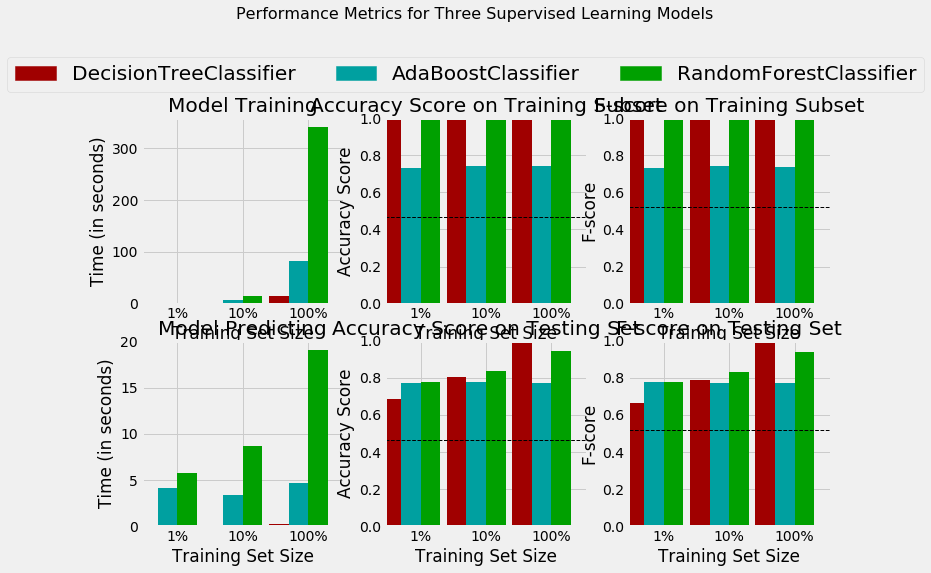

In [128]:
clf_A = DecisionTreeClassifier(random_state = 40)  
clf_B = AdaBoostClassifier (random_state = 40)
clf_C = RandomForestClassifier(random_state = 40)


samples_100 = int(len(X_train))
samples_10 = int(len(X_train)/10)
samples_1 = int(len(X_train)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results, accuracy, fscore)

### Improving Results
In this final section, I will choose from the three supervised learning models the best model to use on the student data. I will then perform a grid search optimization for the model over the entire training set (X_train and y_train) by tuning at least one parameter to improve upon the untuned model's F-score.

In [129]:
# Initialize the classifier
clf = RandomForestClassifier(random_state=2)
#Create the parameters list you wish to tune
max_depth=[5,8]
max_depth.append(None)
scorer = make_scorer(fbeta_score, beta = 0.5)
parameters={'max_features': ['auto'],
            'max_depth' : max_depth,
            'n_estimators': [10,50],
            'min_samples_split': [2,10],
            'min_samples_leaf': [1,4],
           }
# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, cv=3, verbose=2)
# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)
# Get the estimator
best_clf = grid_fit.best_estimator_
# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)
# Report the before-and-afterscores
print ("Unoptimized model\n")
print ("Accuracy score on testing data:", (accuracy_score(y_test, predictions)))
print ("F-score on testing data: ",format(fbeta_score(y_test, predictions, beta = 0.5)))
print ("\nOptimized Model\n")
print ("Final accuracy score on the testing data: ",(accuracy_score(y_test, best_predictions)))
print ("Final F-score on the testing data:",(fbeta_score(y_test, best_predictions, beta = 0.5)))
# Report scores on training dataset
train_predictions = best_clf.predict(X_train)
print ("\nTraining Data\n")
print ("Final accuracy score on the training data: ",(accuracy_score(y_train, train_predictions)))
print ("Final F-score on the training data: ",(fbeta_score(y_train, train_predictions, beta = 0.5)))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=  11.0s
[CV] max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s


[CV]  max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=  14.6s
[CV] max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=  11.4s
[CV] max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=  40.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=  39.3s
[CV] max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=  38.4s
[CV] max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_s

[CV]  max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50, total=  58.3s
[CV] max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=  12.0s
[CV] max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=  12.6s
[CV] max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=  12.3s
[CV] max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50, total=  56.9s
[CV] max_depth=8, max_features=auto, min_samples_leaf=4, min_s

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 46.4min finished


Unoptimized model

Accuracy score on testing data: 0.943852371348246
F-score on testing data:  0.9387244944762605

Optimized Model

Final accuracy score on the testing data:  0.9429088742207554
Final F-score on the testing data: 0.9384008957242955

Training Data

Final accuracy score on the training data:  0.9999092788624524
Final F-score on the training data:  0.9999067036509287


#### Final Model Evaluation
- The optimized model has an accuracy of 86.06% on the test set and an F-score of 0.7316.
- Theses scores are marginally better than those of unoptimized model.
- But, as compared to the naive predictor, the optimized model performs really well. The naive predictor has accuracy of < 46%. The F-score too is much better, for the optimized model.

## Feature Importance

### Extracting Feature Importance

#### in this code:
- Import a supervised learning model from sklearn if it is different from the three used earlier.
- Train the supervised model on the entire training set.
- Extract the feature importances using '.feature_importances_'.

In [130]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = pl.figure(figsize = (9,5))
    pl.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    pl.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    pl.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    pl.xticks(np.arange(5), columns)
    pl.xlim((-0.5, 4.5))
    pl.ylabel("Weight", fontsize = 12)
    pl.xlabel("Feature", fontsize = 12)
    
    pl.legend(loc = 'upper center')
    pl.tight_layout()
    pl.show()  

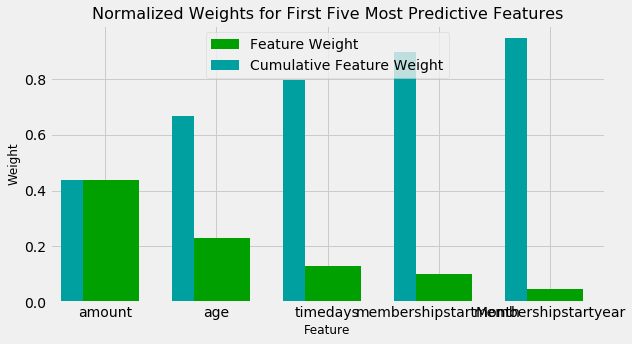

In [131]:
# Train the supervised model on the training set 
model = RandomForestClassifier()
model.fit(X_train, y_train)

importances = model.feature_importances_

# Plot
feature_plot(importances, X_train, y_train)

According to me, age was the most important feature. But in reality, amount is more important than age.

### Feature Selection

In [132]:
# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print ("Final Model trained on full data\n------")
print ("Accuracy on testing data: {:.4f}",(accuracy_score(y_test, best_predictions)))
print ("F-score on testing data: {:.4f}",(fbeta_score(y_test, best_predictions, beta = 0.5)))
print ("\nFinal Model trained on reduced data\n------")
print ("Accuracy on testing data: {:.4f}",(accuracy_score(y_test, reduced_predictions)))
print( "F-score on testing data: {:.4f}",(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: {:.4f} 0.9429088742207554
F-score on testing data: {:.4f} 0.9384008957242955

Final Model trained on reduced data
------
Accuracy on testing data: {:.4f} 0.9851714338100477
F-score on testing data: {:.4f} 0.9862114671408833


## Results 
My analysis suggests that the resulting random forest model has an training data accuracy of 0.944 and an F-score of 0.939. The test data set accuracy of 0.929 and F-score of 0.931 suggests that the random forest model I constructed did not overfit the training data.

# Conclusion
- The problem that I chose to solve was to build a model that predicts how much someone will spend based on demographics and offer type. My strategy for solving this problem has mainly two steps. 
- First, I combined offer portfolio, customer profile, and transaction data. 
- Second, I assessed the accuracy and F-score of a naive model that assumes all offers were successful. 
- Third, I compared the performance of three supervised learning models. This analysis suggests that a random forest model has the best training data accuracy, F-score and Training time. The analysis suggests that the the final model trained on reduced data (random forest model) has accuracy of 0.985 and an F-score of 0.986.